In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14958323829355149910,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10081009664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16443926071426643424
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop


strategy = tf.distribute.MirroredStrategy()

# 라벨
def read_xml_file(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)
    return labels

def read_xml_and_add_labels(image_path, label_directory):
    image_name = os.path.basename(image_path)
    class_name = os.path.dirname(image_path).split(os.path.sep)[-1]
    xml_file_path = os.path.join(label_directory, class_name, image_name[:-4] + '.xml')
    labels = read_xml_file(xml_file_path)
    return labels


with strategy.scope():
    # 데이터증강기법
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
    )

    # 훈련 데이터셋
    train_directory = 'E:/종설/Training/1/[원천]면류'
    train_label_directory = 'E:/종설/Training/2'
    train_dataset = train_datagen.flow_from_directory(
        train_directory,
        target_size=(256, 256),
        batch_size=120,
        shuffle=True,
        seed=42,  # add a seed for reproducibility
        follow_links=True,  # follow symbolic links if any
        classes=None,  # set to None to use default class mode
    )

    # 훈련라벨
    train_labels = []
    for i, image_path in enumerate(train_dataset.filepaths):
        labels = read_xml_and_add_labels(image_path, train_label_directory)
        train_labels.append(labels)


    train_labels = np.array(train_labels)

    # 크기조정만
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
    )

    # 검증데이터
    val_directory = 'E:/종설/Validation/1/[원천]면류'
    val_label_directory = 'E:/종설/Validation/2'
    val_dataset = val_datagen.flow_from_directory(
        val_directory,
        target_size=(256, 256),
        batch_size=120,
        shuffle=False,
        classes=None,  # set to None to use default class mode
    )

    # 검증라벨
    val_labels = []
    for i, image_path in enumerate(val_dataset.filepaths):
        labels = read_xml_and_add_labels(image_path, val_label_directory)
        val_labels.append(labels)

    val_labels = np.array(val_labels)

    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("C:/Users/sj990/MachineLearning/efficientnet_b0_feature-vector_1", trainable=False)

    # 층 추가
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0001)))

    # 컴파일 - 학습률조정
    model.compile(
        optimizer=RMSprop(lr=0.0005),  # Use RMSprop as the optimizer
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    num_epochs = 50
    best_val_acc = 0.0


    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
    )

    # Save the model
    best_val_acc = max(history.history['val_accuracy'])
    model.save('my_model_noodle_v2.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 23370 images belonging to 205 classes.


C:\Users\sj990\AppData\Local\Temp\ipykernel_10844\2542121680.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_labels)


Found 3075 images belonging to 205 classes.


C:\Users\sj990\AppData\Local\Temp\ipykernel_10844\2542121680.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_labels = np.array(val_labels)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50


C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4846: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
195/195 [==============================] - 2641s 14s/step - loss: 3.5854 - accuracy: 0.2553 - val_loss: 1.7357 - val_accuracy: 0.7044
Epoch 2/50
195/195 [======

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 205)               105165    
Total params: 4,810,601
Trainable params: 761,037
Non-trainable params: 4,049,564
_________________________________________________________________


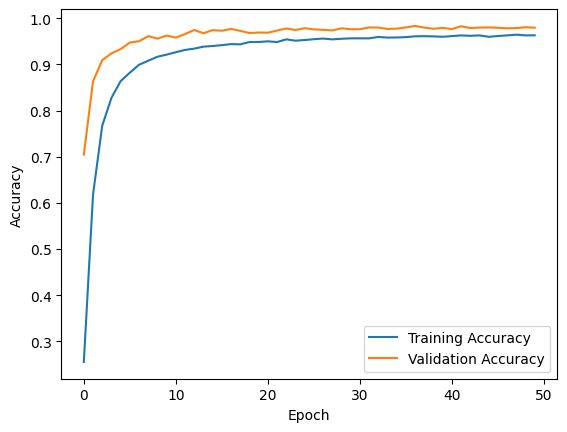

In [3]:
import matplotlib.pyplot as plt

# Get the accuracy values from history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy values
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

# Directory and file paths
directory = 'E:/종설/Training/1/[원천]면류'
class_labels_file = 'class_labels_noodle.txt'
model_file = 'my_model_noodle_v2.h5'

# Step 1: Save class labels to text file
class_labels = []
for filename in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, filename)):
        class_labels.append(filename)

with open(class_labels_file, 'w') as file:
    for label in class_labels:
        file.write(label + '\n')

# Step 2: Load the model
model = tf.keras.models.load_model(model_file, custom_objects={'KerasLayer': hub.KerasLayer})

# Step 3: Load test image and preprocess
img_path = r'C:\Users\sj990\Desktop\ex\456.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

# Step 4: Predict the label of the image
preds = model.predict(img)

# Step 5: Load class labels from the text file
class_labels = []
with open(class_labels_file, 'r') as file:
    for line in file:
        class_labels.append(line.strip())

# Step 6: Get the top three predicted labels and probabilities
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

# Step 7: Print out the top three predicted labels and probabilities
i = 1
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i += 1

결과순위 1: 55041_농심짜왕큰사발면 (1.00)
결과순위 2: 40137_삼양)짜짜로니140G(봉지) (0.00)
결과순위 3: A40029_농심쌀국수 (0.00)
